In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import string
import spacy

/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [7]:
import gensim

https://radimrehurek.com/gensim/models/word2vec.html

In [11]:
gensim.__version__

'3.6.0'

In [13]:
np.random.seed(42)

In [8]:
from gensim.models import word2vec

In [9]:
from gensim.models.word2vec import Word2Vec

#### Using pretrained word-vector

In [10]:
# gensim has an api that we can download that has trained on huge data
import gensim.downloader as api 

In [17]:
# ector-models available
print(gensim.downloader.info()["models"].keys())

dict_keys(['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis'])


First trying smaller vector representation using 50 dimensional "glove-twitter-50" which was trained on twitter data.

In [18]:
wv = api.load("glove-twitter-50")
# this acts like a lookUp or dictionary i.e., when we pass any word it will retain a vector representation of that word

[==================================================] 100.0% 199.5/199.5MB downloaded


In [19]:
type(wv)

gensim.models.keyedvectors.Word2VecKeyedVectors

In [20]:
# example
wv["aeroplane"]

array([-1.1075  ,  0.5215  , -0.26171 ,  0.3382  , -0.18332 ,  0.47509 ,
        0.39695 , -0.70161 ,  0.87691 , -0.31173 ,  0.007826, -0.79057 ,
       -1.1636  , -0.73842 ,  0.17284 , -0.34045 ,  0.091105,  0.090512,
       -0.20105 , -0.12936 , -0.21617 , -0.55929 ,  0.76158 , -0.21148 ,
       -0.090005,  0.77616 , -0.20939 ,  0.026458, -0.43383 ,  0.30525 ,
        0.23116 ,  0.18352 ,  0.84813 , -0.37342 ,  0.59051 ,  0.026781,
        0.45374 , -0.73043 ,  0.18694 ,  0.2084  ,  0.80698 , -0.38954 ,
       -1.0978  , -0.45857 , -0.1947  ,  0.64096 , -0.3901  ,  0.35421 ,
        0.79343 ,  0.74779 ], dtype=float32)

In [22]:
len(wv["aeroplane"])
# as we have downloaded 50 dimensional "glove-twitter-50" which was trained on the twitter data

50

In [24]:
# Checking few methods avaibale
wv.similarity("apple", "mango")

0.5289788

In [25]:
wv.similarity("mango", "aeroplane")

0.2547552

In [28]:
# Checking similarity pairwise
pairs = [
    ("car","minivan"),
    ("car", "communism"),
    ("car", "cereals"),
    ("car", "banana")
]

In [37]:
for w1, w2 in pairs:
    print('%r\t%r\t%.2f' % (w1, w2, wv.similarity(w1, w2)))

# here we can see higher semanitic similarity (in real world) between the "car" and "minivan"

'car'	'minivan'	0.48
'car'	'communism'	0.01
'car'	'cereals'	-0.02
'car'	'banana'	0.34


In [46]:
# top 5 most_similar words
print(wv.most_similar(positive = ["car", "minivan"])[:5])

[('truck', 0.8638960719108582), ('driving', 0.8150991201400757), ('airplane', 0.8137863874435425), ('parked', 0.8027330636978149), ('drove', 0.8020967841148376)]


In [49]:
print(wv.most_similar(positive = ["apple", "mango"])[:5])

[('bean', 0.8290778398513794), ('yogurt', 0.8246266841888428), ('candy', 0.824151337146759), ('orange', 0.8201181888580322), ('soda', 0.8189957141876221)]


In [54]:
# printing odd one out
print(wv.doesnt_match(["apple","mango","strawberry","aeroplane", "orange"]))

aeroplane


Semantic regularities captured in word embeddings

In [60]:
print(wv.most_similar(positive=["woman", "king"], negative = ["man"])[:3])

[('prince', 0.759779691696167), ('stone', 0.7595877051353455), ('queen', 0.754626989364624)]


In [62]:
print(wv.most_similar(positive=["woman", "king"])[:3])

[('guy', 0.8665385246276855), ('called', 0.8582760691642761), ('mother', 0.8502708673477173)]


# Visualizing Word_Vector

In [63]:
words = ["one","two","man","woman","aeroplane"]

In [65]:
sample_vectors = np.array([wv[word] for word in words])
from sklearn.decomposition import PCA          # we use PCA as dimesionality reduction technique
pca = PCA(n_components=2)      # we reduce 50 dimension to only 2
result = pca.fit_transform(sample_vectors)
result

array([[-1.1628251, -1.3557196],
       [-0.8838202, -2.2140431],
       [-1.8871272,  2.5572867],
       [-0.7448811,  0.6350797],
       [ 4.6786537,  0.3773958]], dtype=float32)

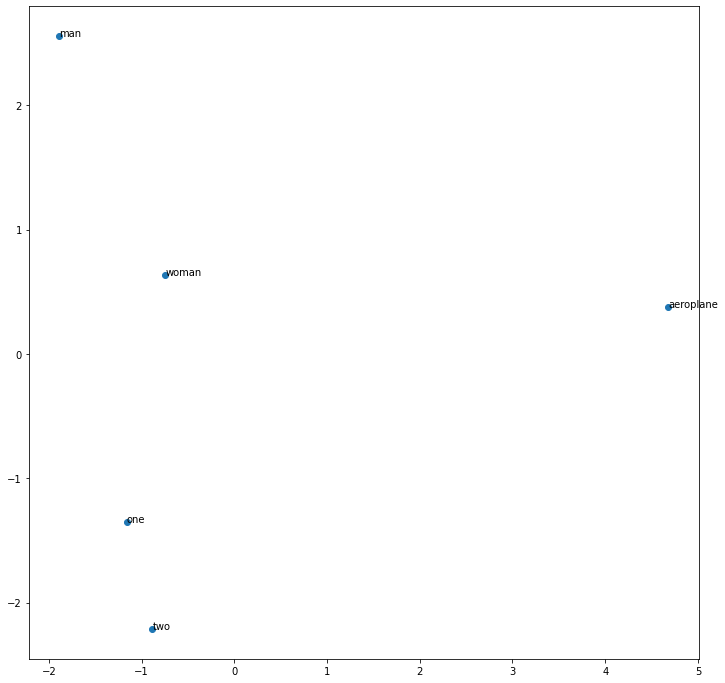

In [69]:
plt.figure(figsize=(12,12))
plt.scatter(result[:,0], result[:,1])
for i, word in enumerate(words):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))
plt.show()

Here, we can see that even in 2 dimenion, vector_represenation has similar semantic in respect to the real real-world scenerio.

# Building Classification Models using this vector representation model

In [79]:
df = pd.read_csv("/content/train.csv")

In [81]:
df = df[["comment_text", "toxic"]]

In [82]:
df.head(3)

,comment_text,toxic
0,explanation why the edits made under my userna...,0.0
1,d aww he matches this background colour i m s...,0.0
2,hey man i m really not trying to edit war it...,0.0


**Using Avaerage approach**

* because lengths of our sentences may vary
* all the sentence should have same length

In [90]:
def sent_vec(sent):
  vector_size = wv.vector_size # attribute of wv
  wv_res = np.zeros(vector_size) # 300 dimensional vetor of zeros
  #print(wv_res)
  ctr = 1
  for w in sent:            # for whatever tokens we have
    if w in wv:             # checking if our work is present in word2vec 
      ctr += 1
      wv_res += wv[w]       # we add vector_representation to zero vector
# We will have all the vectors associated with each word of the sentence in "wv_res"
  
  wv_res = wv_res/ctr # we divide the "wv_res" by number of words
  return wv_res


*Filtering stop_words and punctuations*

In [88]:
# creating our tokenizer function
def spacy_tokenizer(sentence):
  # Creating our token object, which is used to create documents with linguistic annotations
  doc = nlp(sentence)

  

  # print(doc)
  #print(type(doc))

  # Lemmatizing each token and converting each token into lowercase
  my_tokens = [word.lemma_.lower().strip() for word in doc]

  #print(my_tokens)

  # removing stop words
  mytokens = [word for word in my_tokens if word not in stop_words and word not in punctuations]

  #return preprocessed list of tokens
  return mytokens


In [91]:
sent_vec("what a lovely dat!")

array([ 0.1716515 ,  0.16753563, -0.01039983,  0.02757831, -0.13367833,
        0.00745569, -0.53313562,  0.10974294, -0.0982745 ,  0.23556937,
       -0.03320612, -0.07586563, -3.22591254,  0.06404871, -0.08342481,
        0.0164875 , -0.22489937, -0.08447498, -0.283556  ,  0.78138812,
        0.12966144, -0.23691812,  0.23898381,  0.24343257,  0.02304125,
       -1.58985562, -0.1986195 ,  0.04019406,  0.45617956,  0.59941   ,
        0.01801152, -0.20256938,  0.04501432,  0.0276285 ,  0.7671832 ,
        0.39083305, -0.27694175, -0.32127313, -0.57080013,  0.3386555 ,
       -2.35049379,  0.14863913,  0.37737337, -0.13216301,  0.12096563,
        0.07192838, -0.00733538, -0.15668981,  0.25775751, -0.74855582])

Initially we declared everything as zeros and then we modifed with the average of all the word_vectors inside that particular sentence.

In [75]:
# our stop_words list from spacy
nlp = spacy.load("en_core_web_sm")
stop_words = nlp.Defaults.stop_words
print(stop_words)

{'its', 'made', 'my', 'often', 'down', '‘re', 'move', 'been', 'mine', 'various', 'our', 'via', 'up', 'someone', 'enough', 'with', 'doing', 'give', 'seemed', 'have', 'indeed', 'whither', 'off', 'even', 'together', '’ve', 'everything', 'put', 'see', 'any', 'anyhow', 'am', 'whether', 'may', '‘d', 'forty', 'so', 'serious', 'around', 'next', 'meanwhile', 'least', 'some', 'me', 'cannot', 'those', 'using', 'amongst', 'i', 'neither', 'former', 'many', 'such', 'already', 'him', 'is', '‘s', 'therein', 'always', 'eleven', 'must', 'take', 'full', 'you', "'ve", 'hereupon', 'although', 'six', "'s", 'almost', 'nowhere', 'was', 'perhaps', 'seems', 'besides', 'mostly', 'sixty', 'his', 'side', 'after', 'fifteen', 'them', 'whose', 'along', 'formerly', 'might', 'because', 'below', 'really', 'thence', 'throughout', 'will', 'herself', 'do', 'unless', 'whom', 'nor', 'seeming', 'others', 'us', 'only', 'get', 'thereafter', 'more', 'everyone', 'make', 'does', "n't", 'anyway', 'but', 'rather', 'themselves', "'d"

In [77]:
# Similarly for the punctuations from spacy
punctuations = string.punctuation
print(punctuations)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [83]:
df.head(3)

,comment_text,toxic
0,explanation why the edits made under my userna...,0.0
1,d aww he matches this background colour i m s...,0.0
2,hey man i m really not trying to edit war it...,0.0


#### Lets tokenize our comment_text
#### We will get list of words insted of a big string
#### We will also filter stop_words and punctuations

* lets take the column and apply the function we want to apply
* and return in a new column "tokens"

In [84]:
df["tokens"] = df["comment_text"].apply(spacy_tokenizer)

In [85]:
df.head()

,comment_text,toxic,tokens
0,explanation why the edits made under my userna...,0.0,"[explanation, edit, username, hardcore, metall..."
1,d aww he matches this background colour i m s...,0.0,"[d, aww, match, background, colour, m, seeming..."
2,hey man i m really not trying to edit war it...,0.0,"[hey, man, m, try, edit, war, s, guy, constant..."
3,more i can t make any real suggestions on im...,0.0,"[t, real, suggestion, improvement, wonder, sec..."
4,you sir are my hero any chance you remember...,0.0,"[sir, hero, chance, remember, page, s]"


In [92]:
# preforming functions on the newly created "tokens"
df["vec"] = df["tokens"].apply(sent_vec)

In [93]:
df.head()

,comment_text,toxic,tokens,vec
0,explanation why the edits made under my userna...,0.0,"[explanation, edit, username, hardcore, metall...","[0.03735276920577654, 0.3241229636164812, -0.3..."
1,d aww he matches this background colour i m s...,0.0,"[d, aww, match, background, colour, m, seeming...","[0.043267224270563856, 0.0641870077412862, 0.1..."
2,hey man i m really not trying to edit war it...,0.0,"[hey, man, m, try, edit, war, s, guy, constant...","[0.3602050011130897, 0.38256326961246406, -0.2..."
3,more i can t make any real suggestions on im...,0.0,"[t, real, suggestion, improvement, wonder, sec...","[0.3427878192742355, 0.21762503955202797, -0.2..."
4,you sir are my hero any chance you remember...,0.0,"[sir, hero, chance, remember, page, s]","[0.22564857133797236, 0.027462863496371677, 0...."


In [95]:
X = list(df["vec"])
y = list(df["toxic"])

In [96]:
X[0] # 50 dimensional vetor taht we will pass in our ML model

array([ 3.73527692e-02,  3.24122964e-01, -3.23408999e-01,  3.89057885e-02,
        1.71783078e-01, -2.08350806e-01,  3.99181150e-01, -6.42181929e-02,
        1.86881038e-01, -3.67877717e-02,  7.40382329e-02, -7.49710471e-02,
       -2.46146651e+00, -2.11862848e-01, -1.31151730e-01,  3.35647294e-02,
       -8.33865354e-02,  3.62611181e-02, -5.74150011e-02,  2.26414766e-01,
       -1.14365191e-01, -5.55152293e-02, -2.22446504e-04, -7.46765348e-02,
       -1.61116497e-01, -1.79177313e-01,  6.15388470e-02,  2.00854527e-01,
       -7.39579215e-02,  1.81135459e-01,  1.43026919e-01, -4.93590386e-02,
       -3.28437705e-02, -2.57880541e-01,  6.14261355e-01, -5.89584588e-02,
       -6.08373843e-02, -9.90368052e-02,  5.62983493e-02, -1.41597193e-01,
       -4.94367434e-01, -2.02395882e-03,  1.56506115e-01, -5.96953859e-02,
       -7.98849243e-02, -1.26369500e-01, -7.46510778e-02, -3.28581720e-02,
       -1.88991159e-02, -2.21519496e-01])

# train_test_split

In [97]:
from sklearn.model_selection import train_test_split   

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [99]:
from sklearn.linear_model import LogisticRegression

In [100]:
log_model = LogisticRegression()

In [101]:
log_model.fit(X_train, y_train)

LogisticRegression()

# Evaluation

In [102]:
from sklearn.metrics import classification_report

In [103]:
def report(model):
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  print(classification_report(y_test, y_pred))

In [104]:
report(log_model)

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97     28856
         1.0       0.81      0.55      0.66      3059

    accuracy                           0.94     31915
   macro avg       0.88      0.77      0.81     31915
weighted avg       0.94      0.94      0.94     31915

